# Conditional GANS
> The Generator and discriminator of the CGANs are conditioned on additional information such as class labels.

| Class Number      | Name |
| ----------- | ----------- |
| 0   | Airplane      |
| 1   | Automobile    |
| 2   | Bird      |
| 3   | Cat    |
| 4   | Deer      |
| 5   | Dog   |
| 6   | Frog      |
| 7   | Horse    |
| 8   | Ship      |
| 9   | Truck    |

## All required imports

In [66]:
# DL modules
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras import layers
from tensorflow.keras import Sequential, Model
import keras.backend as K
from tensorflow.keras import initializers
! pip install tensorflow_addons
from tensorflow_addons.layers import SpectralNormalization
from tensorflow.keras.optimizers import Adam

# relevent libraries 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

## matplotlib stylings
plt.rcParams['figure.figsize'] = 12, 8

## Constants and hyperparams

In [67]:
batch_size = 128
num_channels = 3
num_classes = 10
image_size = 32
latent_dim = 128

In [68]:
# We'll use all the available examples from both the training and test
# sets.
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
all_digits = np.concatenate([x_train, x_test])
all_labels = np.concatenate([y_train, y_test])


# Conditional GAN takes in labels as the datasets 


In [69]:
# Scale the pixel values to [0, 1] range, add a channel dimension to
# the images, and one-hot encode the labels.
all_digits = all_digits.astype("float32") / 127.5 - 1
all_digits = np.reshape(all_digits, (-1, 32, 32, 3))
all_labels = keras.utils.to_categorical(all_labels, 10)

# Create tf.data.Dataset.
dataset = tf.data.Dataset.from_tensor_slices((all_digits, all_labels))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

print(f"Shape of training images: {all_digits.shape}")
print(f"Shape of training labels: {all_labels.shape}")

Shape of training images: (60000, 32, 32, 3)
Shape of training labels: (60000, 10)


### Conditioning the CGAN to be able to produce class images
> We try to add the latent dimensions and the number of classes in the image so that we can condition the generator to be able to generate images based on classes. This is also true for the discriminator such that the discriminator that distinguish whether an image is fake and also the class of it.

In [70]:
generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes
print(generator_in_channels, discriminator_in_channels)

138 13


In [71]:
# Create the discriminator.
discriminator = keras.Sequential(
    [
        keras.layers.InputLayer((32, 32, discriminator_in_channels)),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.GlobalMaxPooling2D(),
        layers.Dense(1),
    ],
    name="discriminator",
)

# Create the generator.
generator = keras.Sequential(
    [
        keras.layers.InputLayer((generator_in_channels,)),
        # We want to generate 128 + num_classes coefficients to reshape into a
        # 7x7x(128 + num_classes) map.
        layers.Dense(8 * 8 * generator_in_channels),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((8, 8, generator_in_channels)),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, (8, 8), padding="same", activation="sigmoid"),
    ],
    name="generator",
)

In [72]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 16, 16, 64)        7552      
                                                                 
 leaky_re_lu_40 (LeakyReLU)  (None, 16, 16, 64)        0         
                                                                 
 conv2d_25 (Conv2D)          (None, 8, 8, 128)         73856     
                                                                 
 leaky_re_lu_41 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 global_max_pooling2d_8 (Glo  (None, 128)              0         
 balMaxPooling2D)                                                
                                                                 
 dense_16 (Dense)            (None, 1)                 129       
                                                     

In [73]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 8832)              1227648   
                                                                 
 leaky_re_lu_42 (LeakyReLU)  (None, 8832)              0         
                                                                 
 reshape_8 (Reshape)         (None, 8, 8, 138)         0         
                                                                 
 conv2d_transpose_16 (Conv2D  (None, 16, 16, 128)      282752    
 Transpose)                                                      
                                                                 
 leaky_re_lu_43 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_17 (Conv2D  (None, 32, 32, 128)      262272    
 Transpose)                                              

In [74]:
class ConditionalGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        


    def train_step(self, data):
        # Unpack the data.
        real_images, one_hot_labels = data

        # Add dummy dimensions to the labels so that they can be concatenated with
        # the images. This is for the discriminator.
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = tf.repeat(
            image_one_hot_labels, repeats=[image_size * image_size]
        )
        image_one_hot_labels = tf.reshape(
            image_one_hot_labels, (-1, image_size, image_size, num_classes)
        )

        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Decode the noise (guided by labels) to fake images.
        generated_images = self.generator(random_vector_labels)

        # Combine them with real images. Note that we are concatenating the labels
        # with these images here.
        fake_image_and_labels = tf.concat([generated_images, image_one_hot_labels], -1)
        real_image_and_labels = tf.concat([real_images, image_one_hot_labels], -1)
        combined_images = tf.concat(
            [fake_image_and_labels, real_image_and_labels], axis=0
        )

        # Assemble labels discriminating real from fake images.
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )

        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space.
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Assemble labels that say "all real images".
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            fake_image_and_labels = tf.concat([fake_images, image_one_hot_labels], -1)
            predictions = self.discriminator(fake_image_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }

In [75]:
class CONDGANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=100, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        # Create a figure with 10 rows and 10 columns

            
            
        

        fig, axes = plt.subplots(10,10, figsize=(10, 10))
        axes = axes.ravel()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            axes[i].imshow(img)
            axes[i].axis("off")
        title = "Epoch " + str(epoch)

        if (epoch/200 ==1):
            plt.savefig("./Image/CGAN/generated_img_%03d_%d.png",dpi=300)

        plt.suptitle(title)
        plt.show()

        
        
            

Epoch 1/250
469/469 [==============================] - ETA: 0s - g_loss: 3.4197 - d_loss: 0.1485

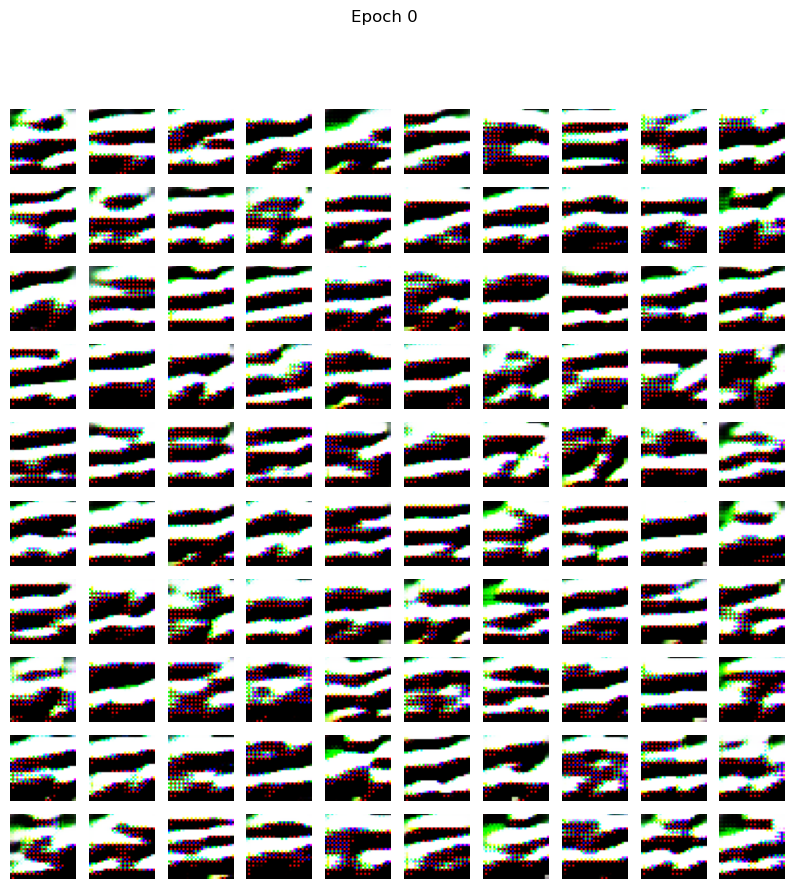

469/469 [==============================] - 77s 162ms/step - g_loss: 3.4220 - d_loss: 0.1483
Epoch 2/250
111/469 [======>.......................] - ETA: 56s - g_loss: 4.8867 - d_loss: 0.0197

KeyboardInterrupt: 

In [76]:
cond_gan = ConditionalGAN(
    discriminator=discriminator, generator=generator, latent_dim=128
)
cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

cond_gan.fit(dataset, epochs=250, callbacks=[CONDGANMonitor(num_img=100, latent_dim=138)])

In [ ]:
# We first extract the trained generator from our Conditiona GAN.
trained_gen = cond_gan.generator

# Choose the number of intermediate images that would be generated in
# between the interpolation + 2 (start and last images).
num_interpolation = 9  # @param {type:"integer"}

# Sample noise for the interpolation.
interpolation_noise = tf.random.normal(shape=(1, latent_dim))
interpolation_noise = tf.repeat(interpolation_noise, repeats=num_interpolation)
interpolation_noise = tf.reshape(interpolation_noise, (num_interpolation, latent_dim))


def interpolate_class(first_number, second_number):
    # Convert the start and end labels to one-hot encoded vectors.
    first_label = keras.utils.to_categorical([first_number], num_classes)
    second_label = keras.utils.to_categorical([second_number], num_classes)
    first_label = tf.cast(first_label, tf.float32)
    second_label = tf.cast(second_label, tf.float32)

    # Calculate the interpolation vector between the two labels.
    percent_second_label = tf.linspace(0, 1, num_interpolation)[:, None]
    percent_second_label = tf.cast(percent_second_label, tf.float32)
    interpolation_labels = (
        first_label * (1 - percent_second_label) + second_label * percent_second_label
    )

    # Combine the noise and the labels and run inference with the generator.
    noise_and_labels = tf.concat([interpolation_noise, interpolation_labels], 1)
    fake = trained_gen.predict(noise_and_labels)
    return fake


start_class = 1  # @param {type:"slider", min:0, max:9, step:1}
end_class = 5  # @param {type:"slider", min:0, max:9, step:1}

fake_images = interpolate_class(start_class, end_class)

In [ ]:
import imageio
import embed
fake_images *= 255.0
converted_images = fake_images.astype(np.uint8)
converted_images = tf.image.resize(converted_images, (96, 96)).numpy().astype(np.uint8)
imageio.mimsave("animation.gif", converted_images, fps=1)
embed.embed_file("animation.gif")